In [2]:
import math
import pylab
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.svm import SVR
import statsmodels.api as sm
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import altair as alt

In [3]:
def get_folds(n, K):
    ### Get the appropriate number of fold labels
    n_fold = math.ceil(n / K) # Number of observations per fold (rounded up)
    fold_ids_raw = list(range(1, K+1)) * n_fold
    fold_ids = fold_ids_raw[:n]
    random.shuffle(fold_ids)
    return fold_ids

def drop_unnamed(df):
    # Drop the column 'Unnamed: 0'
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

def format_date(df):
    # Convert the 'date' column to the 'Y-M' format and set as index
    df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
    df.set_index('date', inplace=True)
    
def df_subset(df, name):
    # Subset the DataFrame based on dates
    if name == 'GDP':
        idx = df['2015-10':].index
    else:
        idx = df['2015-12':].index
    df.drop(idx, inplace=True)
    df.sort_index(ascending=True, inplace=True)
    
def df_rename(df, name):
    # Rename column
    df.rename(columns={'value': name}, inplace=True)

In [67]:
### Read data
cpi = pd.read_csv('data/cpi.csv') # per month from 1913-01-01 to 2022-12-01, total 1320 observations
unemployment = pd.read_csv('data/unemployment.csv') # per month from 1948-01-01 to 2022-12-01, total 900 observations
gdp = pd.read_csv('data/gdp.csv') # per quarter from 1947-01-01 to 2022-07-01, total 303 observations
fund_rate = pd.read_csv('data/fundrate.csv') # per month from 1954-07-01 to 2022-12-01, total 822 observations
retail = pd.read_csv('data/retail.csv') # per month from 1992-01-01 to 2022-12-01, total 372 observations
durables = pd.read_csv('data/durables.csv') # per month from 1992-02-01 to 2022-11-01, total 370 observations
SP500 = pd.read_csv('data/SP500.csv') # per day from 2016-01-04 to 2023-01-13, total 1771 observations
SP500_whole = pd.read_csv('data/SP500_whole.csv') # per day from 1927-12-30 to 2023-01-27, total 23883 observations


In [68]:
### Data Wrangling
for df, name in zip([cpi, unemployment, gdp, fund_rate, durables, retail],
                   ['CPI', 'Unemployment', 'GDP', 'Fund_rate', 'Durables', 'Retail']):
    drop_unnamed(df)
    format_date(df)
    df_subset(df, name)
    df_rename(df, name)

# SP500 is a special one
SP500 = SP500.rename({'Date':'date'}, axis=1)
format_date(SP500)
# Calculate the average value for each month for column 'Close'
SP500 = SP500.groupby('date').mean()
# Subset the DataFrame with dates between 2016-01 and 2022-12
SP500 = SP500['2016-01':'2022-12']
# Only keep the column 'Close'
SP500 = SP500[['Close']]
# Rename the column 'Close' to 'SP500'
SP500.rename(columns={'Close': 'SP500'}, inplace=True)

df = pd.concat([SP500, cpi, unemployment, fund_rate, retail], axis=1)
df


,SP500,CPI,Unemployment,Fund_rate,Retail
date,,,,,
2016-01,1918.597888,236.916,4.8,0.34,351772
2016-02,1904.418494,237.111,4.9,0.38,363527
2016-03,2021.954090,238.132,5.0,0.36,404996
2016-04,2075.535232,239.261,5.1,0.37,394743
2016-05,2065.550479,240.229,4.8,0.37,413036
...,...,...,...,...,...
2022-08,4158.563084,296.171,3.7,2.33,613416
2022-09,3850.520496,296.808,3.5,2.56,577370
2022-10,3726.050956,298.012,3.7,3.08,597349


In [6]:
### Analysis
# Correlation matrix
df.corr()

,SP500,CPI,Unemployment,Fund_rate,Retail
SP500,1.000000,0.873721,0.001425,-0.130268,0.846709
CPI,0.873721,1.000000,-0.107351,0.172674,0.890135
Unemployment,0.001425,-0.107351,1.000000,-0.517548,-0.094071
Fund_rate,-0.130268,0.172674,-0.517548,1.000000,0.064315
Retail,0.846709,0.890135,-0.094071,0.064315,1.000000


In [7]:
# Scatter plots
columns = np.asarray(df.columns)
scatter = alt.Chart(df, height=150, width=150).mark_point(
).encode(
    alt.X(alt.repeat('column'), type = 'quantitative', scale=alt.Scale(zero=False), title=''),
    alt.Y(alt.repeat('row'), type = 'quantitative', scale=alt.Scale(zero=False), title='')
).repeat(
    row = columns, column = columns
)
scatter

alt.RepeatChart(...)

In [8]:
# Trend
df_no_index = df.reset_index()
df_no_index['date'] = df_no_index['date'].dt.to_timestamp().apply(lambda x: x.strftime('%Y-%m'))
trend = alt.Chart(df_no_index, height=100, width=150).mark_line().encode(
    alt.X('date:T'),
    alt.Y(alt.repeat('repeat'), type = 'quantitative', scale=alt.Scale(zero=False))
).repeat(
    repeat = columns, columns = 3
)
trend

alt.RepeatChart(...)

In [9]:
### Data Preprocessing
# Fit time series cross-validation models
X = df.drop(columns='SP500')
Y = df['SP500']
tscv = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Linear regression
    lm = sm.OLS(Y_train, X_train).fit()
    lm_mse = mean_squared_error(Y_test, lm.predict(X_test))
    #print('Linear regression MSE: ', lm_mse)

    # Decision tree
    Tree = DecisionTreeRegressor().fit(X_train, Y_train)
    Tree_mse = mean_squared_error(Y_test, Tree.predict(X_test))
    #print('Decision tree MSE: ', Tree_mse)

    # Random forest
    RF = RandomForestRegressor().fit(X_train, Y_train)
    RF_mse = mean_squared_error(Y_test, RF.predict(X_test))
    #print('Random forest MSE: ', RF_mse)

    # Gradient boosting
    GB = GradientBoostingRegressor().fit(X_train, Y_train)
    GB_mse = mean_squared_error(Y_test, GB.predict(X_test))
    #print('Gradient boosting MSE: ', GB_mse)

    # KNN
    KNN = KNeighborsRegressor().fit(X_train, Y_train)
    KNN_mse = mean_squared_error(Y_test, KNN.predict(X_test))
    #print('KNN MSE: ', KNN_mse)
    
    #print('--------------------------------------')

In [10]:
# Make a scatter plot of the actual vs predicted values
alt.Chart(pd.DataFrame({'Actual': Y_test, 'Linear regression': lm.predict(X_test)})).mark_point().encode(
    alt.X('Actual', scale=alt.Scale(zero=False), title='Actual'),
    alt.Y('Linear regression', scale=alt.Scale(zero=False), title='Predicted')
).properties(title = 'Linear regression')

alt.Chart(...)

In [11]:
alt.Chart(pd.DataFrame({'Actual': Y_test, 'Decision tree': Tree.predict(X_test)})).mark_point().encode(
    alt.X('Actual', scale=alt.Scale(zero=False), title='Actual'),
    alt.Y('Decision tree', scale=alt.Scale(zero=False), title='Predicted')
).properties(title = 'Decision tree')

alt.Chart(...)

In [12]:
alt.Chart(pd.DataFrame({'Actual': Y_test, 'Random forest': RF.predict(X_test)})).mark_point().encode(
    alt.X('Actual', scale=alt.Scale(zero=False), title='Actual'),
    alt.Y('Random forest', scale=alt.Scale(zero=False), title='Predicted')
).properties(title = 'Random forest')

alt.Chart(...)

In [13]:
alt.Chart(pd.DataFrame({'Actual': Y_test, 'Gradient boosting': GB.predict(X_test)})).mark_point().encode(
    alt.X('Actual', scale=alt.Scale(zero=False), title='Actual'),
    alt.Y('Gradient boosting', scale=alt.Scale(zero=False), title='Predicted')
).properties(title = 'Gradient boosting')

alt.Chart(...)

In [14]:
alt.Chart(pd.DataFrame({'Actual': Y_test, 'KNN': KNN.predict(X_test)})).mark_point().encode(
    alt.X('Actual', scale=alt.Scale(zero=False), title='Actual'),
    alt.Y('KNN', scale=alt.Scale(zero=False), title='Predicted')
).properties(title = 'KNN')

alt.Chart(...)

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.062
Date:                Sun, 29 Jan 2023   AIC                            878.125
Time:                        12:22:28   BIC                            884.913
Sample:                    01-31-2016   HQIC                           880.824
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2563      0.700      0.366      0.714      -1.116       1.628
ma.L1         -0.1022      0.697     -0.147      0.883      -1.468       1.264
sigma2      1.265e+04    960.168     13.171      0.0

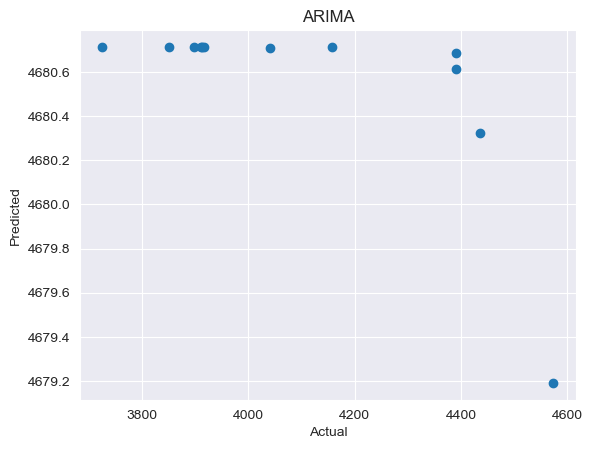

In [15]:
#### Fit an ARIMA (AutoRegressive Integrated Moving Average) model
# Split the data into training and testing sets
SP500_train = SP500[:'2021-12']
SP500_test = SP500['2022-01':]
# fit ARIMA model, specifying the order of the model
ARIMA_model = ARIMA(SP500_train, order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

# Make predictions on the test set
arima_predict = ARIMA_model_fit.predict(start=len(SP500_train), end=len(SP500_train)+11, typ='levels')

# Calculate the MSE
arima_mse = mean_squared_error(SP500_test, arima_predict)

# Make a scatter plot of the actual vs predicted values
plt.scatter(SP500_test, arima_predict)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ARIMA')
plt.show()

In [16]:
# fit Auto ARIMA model, order is automatically selected
auto_arima_model = auto_arima(SP500_train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
# Print model summary
print(auto_arima_model.summary())

# Make predictions on the test set
auto_arima_predict = auto_arima_model.predict(n_periods=len(SP500_test))

# Calculate the MSE
auto_arima_mse = mean_squared_error(SP500_test, auto_arima_predict)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=769.823, Time=0.02 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=747.503, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=747.237, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=769.036, Time=0.03 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=747.400, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=747.430, Time=0.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=747.498, Time=0.07 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=749.311, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=745.740, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=745.585, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=745.699, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=747.158, Time=0.41 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=747.496, Time=0.41 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=745.665, Time=0.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=745.315, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=747.139, Time=0.15 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=747.132, Time=0.16 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=746.256, Time=0.24 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 3.310 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -369.658
Date:                            Sun, 29 Jan 2023   AIC                            745.315
Time:                                    12:22:32   BIC                            751.548
Sample:                                01-31-2016   HQIC                           747.748
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025

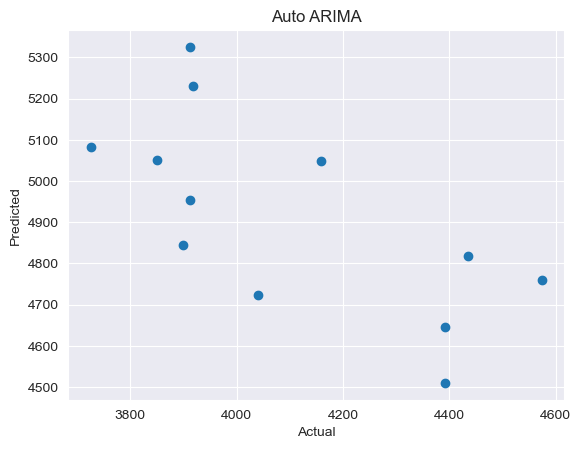

In [17]:
# Make a scatter plot of the actual vs predicted values
plt.scatter(SP500_test, auto_arima_predict)
plt.title('Auto ARIMA')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [23]:
# Make a table of MSE adding ARIMA and Auto ARIMA models
MSE = pd.DataFrame({'MSE': [lm_mse, Tree_mse, RF_mse, GB_mse, KNN_mse, arima_mse, auto_arima_mse]},
                        index=['Linear Regression', 'Decision Tree', 'Random Forest',
                                 'Gradient Boosting', 'KNN', 'ARIMA', 'Auto ARIMA'])
MSE

,MSE
Linear Regression,33395.694210
Decision Tree,30974.391258
Random Forest,120233.598791
Gradient Boosting,37853.293824
KNN,245160.671388
ARIMA,408075.669961
Auto ARIMA,875067.620844


In [19]:
# convert index to a column
MSE.reset_index(inplace=True)
MSE.rename(columns={'index': 'Model'}, inplace=True)

# Make a MSE plot
alt.Chart(MSE).mark_bar().encode(
    alt.X('Model', sort='-y'),
    alt.Y('MSE')
).properties(title = 'MSE of different models', width = 500)

alt.Chart(...)

In [24]:
# Make a relative MSE plot
MSE['Relative MSE'] = MSE['MSE'] / MSE['MSE'].min()
alt.Chart(MSE).mark_bar().encode(
    alt.X('Model', sort='-y'),
    alt.Y('Relative MSE')
).properties(title = 'Relative MSE of different models', width = 500)

ValueError: Model encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.Chart(...)

In [85]:
#### Fit an ARIMA (AutoRegressive Integrated Moving Average) model on SP500_whole dataset

### Data Wrangling
SP500_whole = pd.read_csv('data/SP500_whole.csv') # per day from 1927-12-30 to 2023-01-27, total 23883 observations

SP500_whole = SP500_whole.rename({'Date':'date'}, axis=1)
format_date(SP500_whole)
# Calculate the average value for each month for column 'Close'
SP500_whole = SP500_whole.groupby('date').mean()
# Subset the DataFrame with dates between 2016-01 and 2022-12
#SP500 = SP500['2016-01':'2022-12']
# Only keep the column 'Close'
SP500_whole = SP500_whole[['Close']]
# Rename the column 'Close' to 'SP500'
SP500_whole.rename(columns={'Close': 'SP500'}, inplace=True)

SP500_whole # per month from 1927-12 to 2023-01, total 1142 observations

,SP500
date,
1927-12,17.660000
1928-01,17.520000
1928-02,17.324211
1928-03,18.233182
1928-04,19.371000
...,...
2022-09,3850.520496
2022-10,3726.050956
2022-11,3917.488595


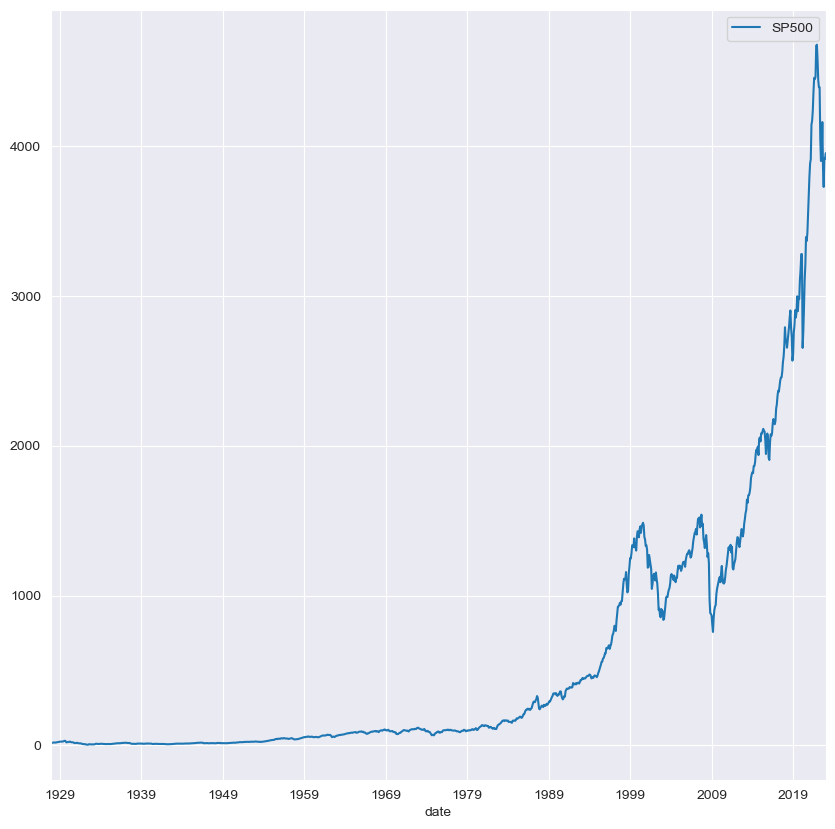

In [87]:
# Make a plot of SP500_whole
SP500_whole.plot(subplots=True, figsize=(10, 10))
plt.show()

In [97]:
# Split the data into training and testing sets
SP500_whole_train = SP500_whole[:'2021-12']
SP500_whole_test = SP500_whole['2022-01':]

# fit ARIMA model, specifying the order of the model
ARIMA_whole_model = ARIMA(SP500_whole_train, order=(1, 1, 1))
ARIMA_whole_model_fit = ARIMA_whole_model.fit()
print(ARIMA_whole_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                 1129
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5619.826
Date:                Sun, 29 Jan 2023   AIC                          11245.652
Time:                        13:02:17   BIC                          11260.737
Sample:                    12-31-1927   HQIC                         11251.352
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0745      0.062      1.202      0.229      -0.047       0.196
ma.L1          0.1048      0.061      1.704      0.088      -0.016       0.225
sigma2      1244.2854      8.339    149.205      0.0

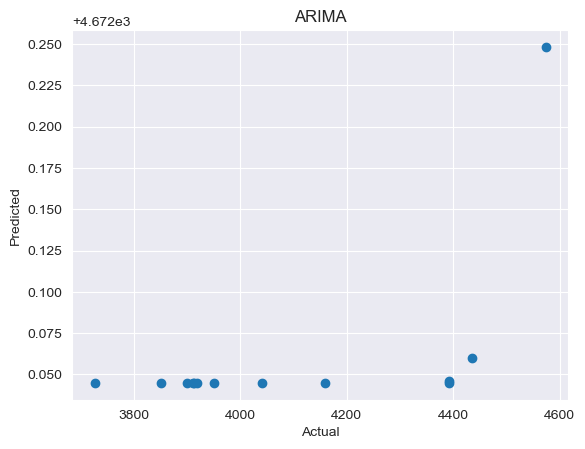

In [103]:
# Make predictions on the test set
arima_whole_predict = ARIMA_whole_model_fit.predict(start=len(SP500_whole_train), end=len(SP500_whole_train)+12, typ='levels')
# Calculate the MSE
arima_whole_mse = mean_squared_error(SP500_whole_test, arima_whole_predict)
# Make a scatter plot of the actual vs predicted values
plt.scatter(SP500_whole_test, arima_whole_predict)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ARIMA')
plt.show()


In [104]:
# fit Auto ARIMA model, order is automatically selected
auto_arima_whole_model = auto_arima(SP500_whole_train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
# Print model summary
print(auto_arima_whole_model.summary())


Performing stepwise search to minimize aic


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=11814.942, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11374.889, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=11773.246, Time=0.05 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11296.239, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11311.479, Time=0.48 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11295.363, Time=0.90 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11376.378, Time=0.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11297.331, Time=1.16 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=11297.347, Time=1.70 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=11295.904, Time=1.18 sec


/Users/ju/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(2,1,0)[12]             : AIC=11299.298, Time=2.08 sec
 ARIMA(2,1,0)(2,1,0)[12] intercept   : AIC=11296.082, Time=3.32 sec

Best model:  ARIMA(2,1,0)(2,1,0)[12]          
Total fit time: 24.088 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1129
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -5642.681
Date:                            Sun, 29 Jan 2023   AIC                          11295.363
Time:                                    13:04:01   BIC                          11320.450
Sample:                                12-31-1927   HQIC                         11304.847
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|   

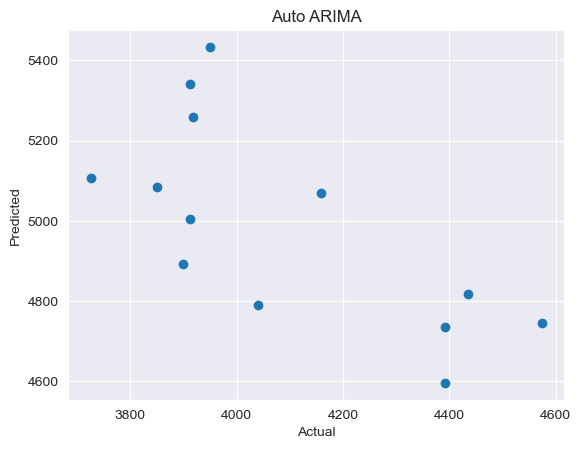

In [106]:
# Make predictions on the test set
auto_arima_whole_predict = auto_arima_whole_model.predict(n_periods=len(SP500_whole_test))
# Calculate the MSE
auto_arima_whole_mse = mean_squared_error(SP500_whole_test, auto_arima_whole_predict)

# Make a scatter plot of the actual vs predicted values
plt.scatter(SP500_whole_test, auto_arima_whole_predict)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Auto ARIMA')
plt.show()


In [108]:
# Make a table of MSE from ARIMA and Auto ARIMA models
MSE_whole = pd.DataFrame({'MSE': [arima_whole_mse, auto_arima_whole_mse]},
                        index=['ARIMA', 'Auto ARIMA'])
MSE_whole

,MSE
ARIMA,4.075097e+05
Auto ARIMA,1.029425e+06
